In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.stats import norm
import gpytorch

# Set plotting style and random seeds
plt.style.use('seaborn-v0_8')
np.random.seed(0)
torch.manual_seed(0)

## Generate Data

$$
y = \sin(x) + \epsilon
$$

where $\epsilon \in N(0, \sigma_{\epsilon})$

In [24]:
def generate_data(n_samples=20, noise_std=0.1):
    """
    Generate synthetic data for testing uncertainty estimation methods.
    
    Args:
        n_samples: Number of training points to generate
        noise_std: Standard deviation of noise to add to the sine function
        
    Returns:
        X: Input points
        y: Noisy target values
    """
    X = np.linspace(-3, 3, n_samples)
    y = np.sin(X) + np.random.normal(0, noise_std, n_samples)
    return X, y

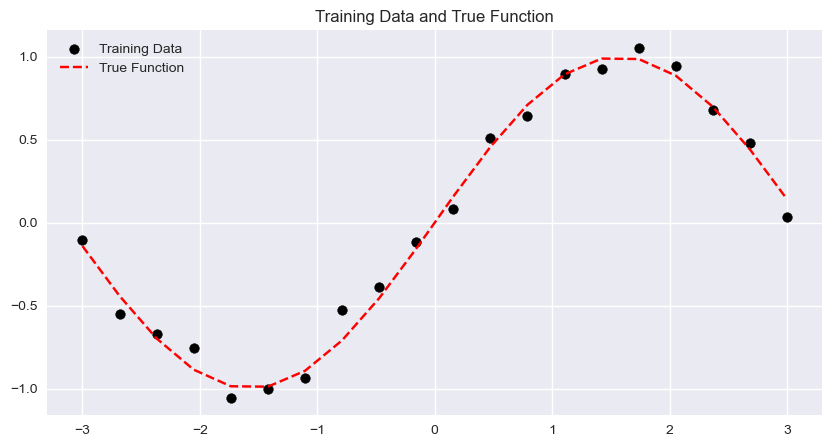

In [25]:
data = generate_data()

X_train, y_train = generate_data()
plt.figure(figsize=(10, 5))
plt.scatter(X_train, y_train, c='black', label='Training Data')
plt.plot(X_train, np.sin(X_train), 'r--', label='True Function')
plt.legend()
plt.title('Training Data and True Function')
plt.show()

## Monte-Carlo Dropout Method

In [30]:
class DropoutNet(nn.Module):
    """Neural network with dropout for uncertainty estimation"""
    def __init__(self, dropout_rate=0.2):
        super(DropoutNet, self).__init__()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(1, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 1)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

def train_mc_dropout(model, X, y, epochs=10000):
    """Train the MC Dropout network"""
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    X_tensor = torch.FloatTensor(X).reshape(-1, 1)
    y_tensor = torch.FloatTensor(y).reshape(-1, 1)
    
    losses = []  # Store losses for plotting
    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(X_tensor)
        loss = criterion(output, y_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item():.4f}')
    
    # Plot training curve
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title('MC Dropout Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.show()

## Gaussian Process

In [31]:
class ExactGPModel(gpytorch.models.ExactGP):
    """Gaussian Process model with RBF kernel"""
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def train_gp(X_train, y_train, n_iterations=100):
    """Train the Gaussian Process model"""
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    X_train_tensor = torch.FloatTensor(X_train).reshape(-1, 1)
    y_train_tensor = torch.FloatTensor(y_train)
    
    model = ExactGPModel(X_train_tensor, y_train_tensor, likelihood)
    model.train()
    likelihood.train()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    
    losses = []
    for i in range(n_iterations):
        optimizer.zero_grad()
        output = model(X_train_tensor)
        loss = -mll(output, y_train_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
        if i % 10 == 0:
            print(f'Iteration {i}, Loss: {loss.item():.4f}')
    
    # Plot training curve
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title('GP Training Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Negative Log Likelihood')
    plt.show()
    
    return model, likelihood

## Predictions


### MC Dropout Predcitions

In [32]:
def mc_dropout_predict(model, X, n_samples=100):
    """Make predictions with MC Dropout"""
    model.train()  # Enable dropout
    predictions = []
    X_tensor = torch.FloatTensor(X).reshape(-1, 1)
    
    for _ in range(n_samples):
        predictions.append(model(X_tensor).detach().numpy())
    
    predictions = np.array(predictions)
    mean = predictions.mean(axis=0)
    std = predictions.std(axis=0)
    return mean, std

def gp_predict(model, likelihood, X):
    """Make predictions with Gaussian Process"""
    model.eval()
    likelihood.eval()
    X_tensor = torch.FloatTensor(X).reshape(-1, 1)
    
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = likelihood(model(X_tensor))
        mean = observed_pred.mean.numpy()
        std = observed_pred.stddev.numpy()
    return mean, std

In [33]:
def compare_methods(X_train, y_train, X_test):
    """Compare MC Dropout and GP predictions"""
    # Train MC Dropout
    dropout_model = DropoutNet()
    train_mc_dropout(dropout_model, X_train, y_train)
    mc_mean, mc_std = mc_dropout_predict(dropout_model, X_test)
    
    # Train GP
    gp_model, likelihood = train_gp(X_train, y_train)
    gp_mean, gp_std = gp_predict(gp_model, likelihood, X_test)
    
    # Plotting
    plt.figure(figsize=(15, 5))
    
    # MC Dropout plot
    plt.subplot(1, 2, 1)
    plt.scatter(X_train, y_train, c='black', label='Training Data')
    plt.plot(X_test, mc_mean, 'b-', label='Mean Prediction')
    plt.fill_between(X_test.flatten(), 
                    mc_mean.flatten() - 2*mc_std.flatten(),
                    mc_mean.flatten() + 2*mc_std.flatten(),
                    alpha=0.3, label='95% Confidence')
    plt.plot(X_test, np.sin(X_test), 'r--', label='True Function')
    plt.title('MC Dropout')
    plt.legend()
    
    # Gaussian Process plot
    plt.subplot(1, 2, 2)
    plt.scatter(X_train, y_train, c='black', label='Training Data')
    plt.plot(X_test, gp_mean, 'b-', label='Mean Prediction')
    plt.fill_between(X_test.flatten(),
                    gp_mean - 2*gp_std,
                    gp_mean + 2*gp_std,
                    alpha=0.3, label='95% Confidence')
    plt.plot(X_test, np.sin(X_test), 'r--', label='True Function')
    plt.title('Gaussian Process')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

Epoch 0, Loss: 0.5506
Epoch 100, Loss: 0.0466
Epoch 200, Loss: 0.0428
Epoch 300, Loss: 0.0492
Epoch 400, Loss: 0.0301
Epoch 500, Loss: 0.0334
Epoch 600, Loss: 0.0316
Epoch 700, Loss: 0.0416
Epoch 800, Loss: 0.0230
Epoch 900, Loss: 0.0414
Epoch 1000, Loss: 0.0254
Epoch 1100, Loss: 0.0119
Epoch 1200, Loss: 0.0227
Epoch 1300, Loss: 0.0263
Epoch 1400, Loss: 0.0158
Epoch 1500, Loss: 0.0221
Epoch 1600, Loss: 0.0368
Epoch 1700, Loss: 0.0231
Epoch 1800, Loss: 0.0173
Epoch 1900, Loss: 0.0120
Epoch 2000, Loss: 0.0111
Epoch 2100, Loss: 0.0247
Epoch 2200, Loss: 0.0228
Epoch 2300, Loss: 0.0136
Epoch 2400, Loss: 0.0174
Epoch 2500, Loss: 0.0242
Epoch 2600, Loss: 0.0065
Epoch 2700, Loss: 0.0121
Epoch 2800, Loss: 0.0160
Epoch 2900, Loss: 0.0119
Epoch 3000, Loss: 0.0345
Epoch 3100, Loss: 0.0124
Epoch 3200, Loss: 0.0174
Epoch 3300, Loss: 0.0229
Epoch 3400, Loss: 0.0225
Epoch 3500, Loss: 0.0139
Epoch 3600, Loss: 0.0152
Epoch 3700, Loss: 0.0107
Epoch 3800, Loss: 0.0208
Epoch 3900, Loss: 0.0199
Epoch 4000, 

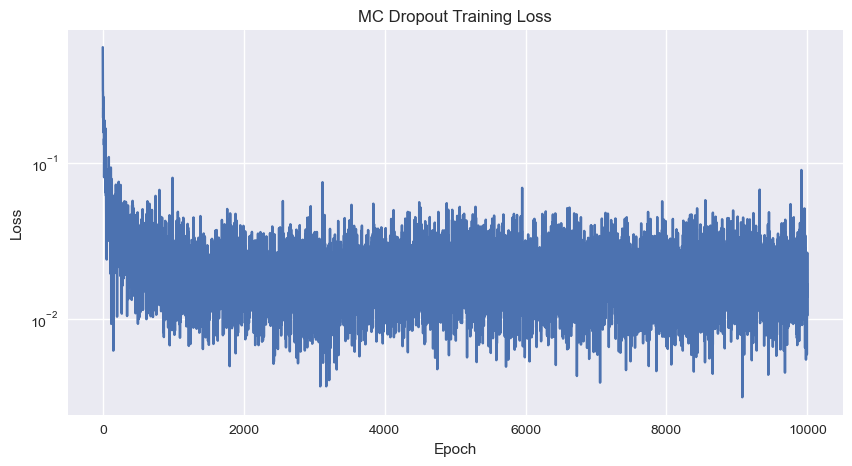

Iteration 0, Loss: 1.0316
Iteration 10, Loss: 0.6625
Iteration 20, Loss: 0.3385
Iteration 30, Loss: 0.0250
Iteration 40, Loss: -0.2152
Iteration 50, Loss: -0.3231
Iteration 60, Loss: -0.3211
Iteration 70, Loss: -0.3234
Iteration 80, Loss: -0.3289
Iteration 90, Loss: -0.3283


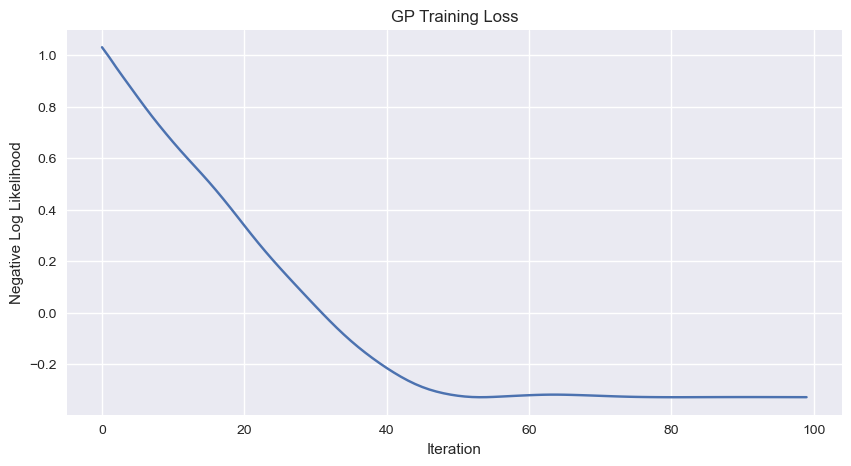

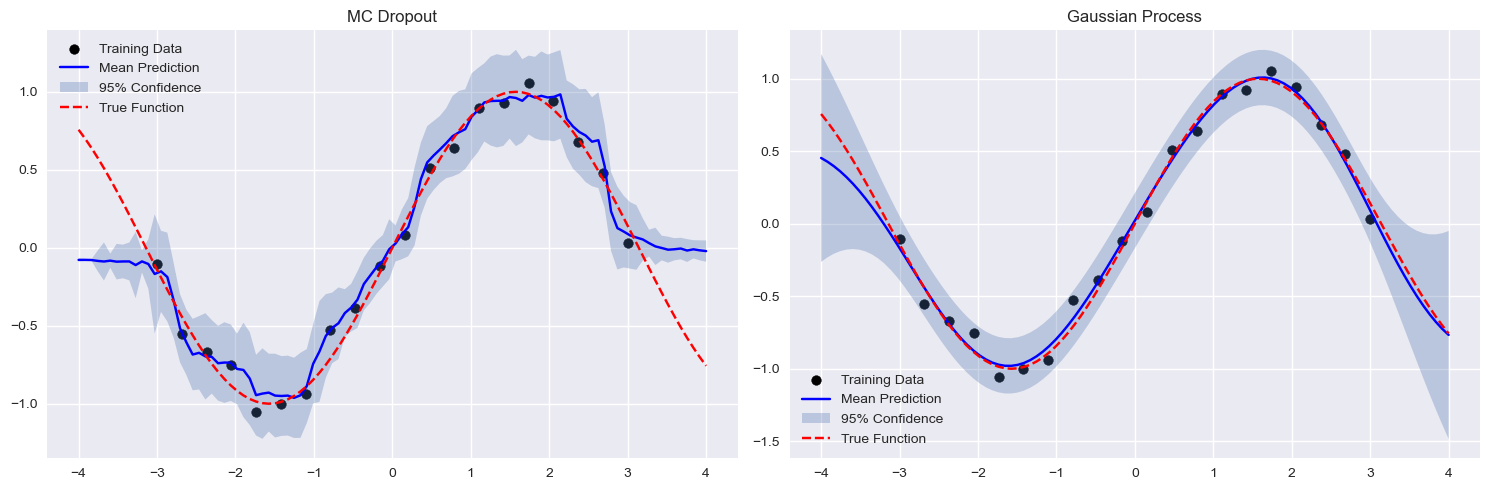

In [34]:
X_test = np.linspace(-4, 4, 100)

# Run comparison
compare_methods(X_train, y_train, X_test)